In [346]:
import os
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch
import os
import torchvision.models as models
import torch.nn as nn

import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mtcnn import MTCNN
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

In [347]:
# GLOBAL VARS
training_size_perc = 1
epochs = 2
learning_rate_network = 3e-4
learning_rate_model = 3e-3

In [348]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)

scene_feature365_dir = os.path.join(base_dir, "data", "FindingEmo_Images", "precomputed", "scenes")
print("scene_feature365_dir:", scene_feature365_dir)
faces_feature_dir = os.path.join(base_dir, "data", "FindingEmo_Images", "precomputed", "faces")
print("faces_feature_dir:", faces_feature_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
scene_feature365_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\precomputed\scenes
faces_feature_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\precomputed\faces


In [349]:
emotion_categories_hf = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]

EMO8_LIST = [l[1] for l in EMOTION_SETS]

In [350]:
df = pd.read_csv(os.path.join(findingemo_dir, "annotations_single.ann"))
# Delete the columns: "user" and "index" and "datetime"
if "user" in df.columns and "index" in df.columns and "datetime" in df.columns:
    df = df.drop(columns=["user", "index", "datetime"])

# remove leading slash from image_path
if df["image_path"].iloc[0].startswith("/"):
    df["image_path"] = df["image_path"].str.lstrip("/")

In [351]:
# Apply the mapping to 8 emotions as defined in the FindingEmo code
EMO8_MAPPING = {}

for i, leaf in enumerate(EMOTION_SETS):
    for emo in leaf:
        EMO8_MAPPING[emo] = EMO8_LIST[i]

df['emotion_8'] = df['emotion'].map(EMO8_MAPPING)

In [352]:
# Delete all the rows that contain the emotion_8 as "trust" and "anticipation"
for emo in ["Trust", "Anticipation"]:
    df = df[df['emotion_8'] != emo]

df

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,emotion_8
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,Apprehension,ConflictCtxtPerson,0,Fear
7,Run_2/Scared adolescents prison/15-hampton-roa...,Undefined,"Youth,Adults",0,3,Anger,"BodyLanguage,FacialExpression",0,Anger
8,Run_2/Raging students party/Newly-elected-Nepa...,Undefined,"Young Adults,Adults",0,2,Joy,"BodyLanguage,FacialExpression",0,Joy
10,Run_1/Accepting children school/whitecoatcerem...,Undefined,Young Adults,0,0,Joy,FacialExpression,0,Joy
11,Run_1/Grateful youth protest/trees3.jpg,Undefined,Adults,-1,3,Fear,"BodyLanguage,Staging",3,Fear
...,...,...,...,...,...,...,...,...,...
25858,Run_2/Appalled soldiers court/Myanmars-Militar...,Undefined,Children,-2,4,Grief,"FacialExpression,Staging",1,Sadness
25860,Run_2/Raging twenty-something funeral/Mideast-...,Undefined,Adults,-2,4,Sadness,"Neutral,Context",3,Sadness
25862,Run_2/Outraged fifty-something hospital/Q3VE4A...,Undefined,Adults,-2,5,Surprise,"ConflictCtxtPerson,Staging",4,Surprise
25865,Run_2/Disgusted children anniversary/8-May-200...,Undefined,Adults,0,3,Loathing,BodyLanguage,3,Disgust


In [353]:
# get the different emo8's  
basic_6_emotions = ["Anger", "Disgust", "Fear", "Joy", "Sadness", "Surprise"]
basic_6_emotions_idx = {emo: i for i, emo in enumerate(basic_6_emotions)}

In [354]:
basic_6_emotions_idx

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Joy': 3, 'Sadness': 4, 'Surprise': 5}

In [355]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print(scene_categories)

['airfield', 'airplane_cabin', 'airport_terminal', 'alcove', 'alley', 'amphitheater', 'amusement_arcade', 'amusement_park', 'apartment_building_outdoor', 'aquarium', 'aqueduct', 'arcade', 'arch', 'archaelogical_excavation', 'archive', 'arena_hockey', 'arena_performance', 'arena_rodeo', 'army_base', 'art_gallery', 'art_school', 'art_studio', 'artists_loft', 'assembly_line', 'athletic_field_outdoor', 'atrium_public', 'attic', 'auditorium', 'auto_factory', 'auto_showroom', 'badlands', 'bakery_shop', 'balcony_exterior', 'balcony_interior', 'ball_pit', 'ballroom', 'bamboo_forest', 'bank_vault', 'banquet_hall', 'bar', 'barn', 'barndoor', 'baseball_field', 'basement', 'basketball_court_indoor', 'bathroom', 'bazaar_indoor', 'bazaar_outdoor', 'beach', 'beach_house', 'beauty_salon', 'bedchamber', 'bedroom', 'beer_garden', 'beer_hall', 'berth', 'biology_laboratory', 'boardwalk', 'boat_deck', 'boathouse', 'bookstore', 'booth_indoor', 'botanical_garden', 'bow_window_indoor', 'bowling_alley', 'boxin

In [356]:
places365_to_13categories = {
    # --- Transport infrastructure ---
    "airfield": "transport_infrastructure",
    "airplane_cabin": "transport_infrastructure",
    "airport_terminal": "transport_infrastructure",
    "railroad_track": "transport_infrastructure",
    "train_interior": "transport_infrastructure",
    "train_station_platform": "transport_infrastructure",
    "subway_station_platform": "transport_infrastructure",
    "bridge": "transport_infrastructure",
    "runway": "transport_infrastructure",
    "highway": "transport_infrastructure",
    "garage_indoor": "transport_infrastructure",
    "garage_outdoor": "transport_infrastructure",
    "bus_interior": "transport_infrastructure",
    "bus_station_indoor": "transport_infrastructure",
    "harbor": "transport_infrastructure",
    "viaduct": "transport_infrastructure",
    "heliport": "transport_infrastructure",
    "parking_garage_indoor": "transport_infrastructure",
    "parking_garage_outdoor": "transport_infrastructure",
    "car_interior": "transport_infrastructure",
    "cockpit": "transport_infrastructure",
    "berth": "transport_infrastructure",

    # --- Indoor residential ---
    "bedroom": "indoor_residential",
    "bathroom": "indoor_residential",
    "living_room": "indoor_residential",
    "kitchen": "indoor_residential",
    "attic": "indoor_residential",
    "childs_room": "indoor_residential",
    "closet": "indoor_residential",
    "dining_room": "indoor_residential",
    "dorm_room": "indoor_residential",
    "hotel_room": "indoor_residential",
    "mansion": "indoor_residential",
    "nursery": "indoor_residential",
    "television_room": "indoor_residential",
    "pantry": "indoor_residential",
    "playroom": "indoor_residential",
    "house": "indoor_residential",
    "apartment_building_outdoor": "indoor_residential",
    "balcony_interior": "indoor_residential",
    "banquet_hall": "indoor_residential",
    "porch": "indoor_residential",
    "jacuzzi_indoor": "indoor_residential",
    "shower": "indoor_residential",
    "alcove": "indoor_residential",
    "bedchamber": "indoor_residential",
    "ballroom": "indoor_residential",
    "basement": "indoor_residential",
    "dressing_room": "indoor_residential",
    "home_office": "indoor_residential",
    "home_theater": "indoor_residential",
    "manufactured_home": "indoor_residential",
    "utility_room": "indoor_residential",
    "wet_bar": "indoor_residential",
    "youth_hostel": "indoor_residential",

    # --- Indoor commercial ---
    "bakery_shop": "indoor_commercial",
    "bar": "indoor_commercial",
    "bookstore": "indoor_commercial",
    "butchers_shop": "indoor_commercial",
    "candy_store": "indoor_commercial",
    "clothing_store": "indoor_commercial",
    "department_store": "indoor_commercial",
    "fastfood_restaurant": "indoor_commercial",
    "florist_shop_indoor": "indoor_commercial",
    "gift_shop": "indoor_commercial",
    "jewelry_shop": "indoor_commercial",
    "market_indoor": "indoor_commercial",
    "pet_shop": "indoor_commercial",
    "pharmacy": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "toyshop": "indoor_commercial",
    "restaurant": "indoor_commercial",
    "restaurant_kitchen": "indoor_commercial",
    "restaurant_patio": "indoor_commercial",
    "pizzeria": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sushi_bar": "indoor_commercial",
    "hotel_outdoor": "indoor_commercial",
    "amusement_arcade": "indoor_commercial",
    "auto_showroom": "indoor_commercial",
    "bakery_shop": "indoor_commercial",
    "bank_vault": "indoor_commercial",
    "bazaar_indoor": "indoor_commercial",
    "beauty_salon": "indoor_commercial",
    "cafeteria": "indoor_commercial",
    "coffee_shop": "indoor_commercial",
    "delicatessen": "indoor_commercial",
    "discotheque": "indoor_commercial",
    "drugstore": "indoor_commercial",
    "fabric_store": "indoor_commercial",
    "flea_market_indoor": "indoor_commercial",
    "food_court": "indoor_commercial",
    "hardware_store": "indoor_commercial",
    "laundromat": "indoor_commercial",
    "market_outdoor": "indoor_commercial",
    "motel": "indoor_commercial",
    "pub_indoor": "indoor_commercial",
    "sauna": "indoor_commercial",
    "server_room": "indoor_commercial",
    "shoe_shop": "indoor_commercial",
    "shopping_mall_indoor": "indoor_commercial",
    "supermarket": "indoor_commercial",
    "booth_indoor": "indoor_commercial",
    "ice_cream_parlor": "indoor_commercial",
    "general_store_indoor": "indoor_commercial",
    "general_store_outdoor": "indoor_commercial",
    "pavilion": "indoor_commercial",
    "ticket_booth": "indoor_commercial",

    # --- Indoor institutional ---
    "art_gallery": "indoor_institutional",
    "auditorium": "indoor_institutional",
    "church_indoor": "indoor_institutional",
    "classroom": "indoor_institutional",
    "conference_room": "indoor_institutional",
    "hospital": "indoor_institutional",
    "hospital_room": "indoor_institutional",
    "library_indoor": "indoor_institutional",
    "lecture_room": "indoor_institutional",
    "office": "indoor_institutional",
    "office_cubicles": "indoor_institutional",
    "schoolhouse": "indoor_institutional",
    "science_museum": "indoor_institutional",
    "nursing_home": "indoor_institutional",
    "reception": "indoor_institutional",
    "waiting_room": "indoor_institutional",
    "museum_indoor": "indoor_institutional",
    "biology_laboratory": "indoor_institutional",
    "chemistry_lab": "indoor_institutional",
    "clean_room": "indoor_institutional",
    "conference_center": "indoor_institutional",
    "courthouse": "indoor_institutional",
    "embassy": "indoor_institutional",
    "entrance_hall": "indoor_institutional",
    "elevator_lobby": "indoor_institutional",
    "elevator_shaft": "indoor_institutional",
    "elevator_door": "indoor_institutional",
    "escalator_indoor": "indoor_institutional",
    "hospital": "indoor_institutional",
    "kindergarden_classroom": "indoor_institutional",
    "legislative_chamber": "indoor_institutional",
    "library_outdoor": "indoor_institutional",
    "lobby": "indoor_institutional",
    "locker_room": "indoor_institutional",
    "operating_room": "indoor_institutional",
    "physics_laboratory": "indoor_institutional",
    "recreation_room": "indoor_institutional",
    "veterinarians_office": "indoor_institutional",
    "atrium_public": "indoor_institutional",
    "corridor": "indoor_institutional",
    "computer_room": "indoor_institutional",
    "mezzanine": "indoor_institutional",
    "office_building": "indoor_institutional",
    "jail_cell": "indoor_institutional",
    "storage_room": "indoor_institutional",

    # --- Industrial facilities ---
    "assembly_line": "industrial_facility",
    "auto_factory": "industrial_facility",
    "engine_room": "industrial_facility",
    "industrial_area": "industrial_facility",
    "oilrig": "industrial_facility",
    "construction_site": "industrial_facility",
    "army_base": "industrial_facility",
    "junkyard": "industrial_facility",
    "repair_shop": "industrial_facility",
    "loading_dock": "industrial_facility",
    "fire_station": "industrial_facility",
    "landing_deck": "industrial_facility",
    "construction_site": "industrial_facility",
    "gas_station": "industrial_facility",
    "hangar_indoor": "industrial_facility",
    "hangar_outdoor": "industrial_facility",
    "dam": "industrial_facility",
    "excavation": "industrial_facility",
    "fire_escape": "industrial_facility",
    "landfill": "industrial_facility",
    "lock_chamber": "industrial_facility",
    "trench": "industrial_facility",
    "shed": "industrial_facility",

    # --- Urban outdoor ---
    "alley": "urban_outdoor",
    "building_facade": "urban_outdoor",
    "courtyard": "urban_outdoor",
    "crosswalk": "urban_outdoor",
    "downtown": "urban_outdoor",
    "plaza": "urban_outdoor",
    "street": "urban_outdoor",
    "shopfront": "urban_outdoor",
    "parking_lot": "urban_outdoor",
    "residential_neighborhood": "urban_outdoor",
    "skyscraper": "urban_outdoor",
    "amusement_park": "urban_outdoor",
    "arcade": "urban_outdoor",
    "balcony_exterior": "urban_outdoor",
    "bazaar_outdoor": "urban_outdoor",
    "boardwalk": "urban_outdoor",
    "driveway": "urban_outdoor",
    "doorway_outdoor": "urban_outdoor",
    "gazebo_exterior": "urban_outdoor",
    "market_outdoor": "urban_outdoor",
    "patio": "urban_outdoor",
    "plaza": "urban_outdoor",
    "promenade": "urban_outdoor",
    "rope_bridge": "urban_outdoor",
    "street": "urban_outdoor",
    "tower": "urban_outdoor",
    "slum": "urban_outdoor",
    "sky": "urban_outdoor",
    "roof_garden": "urban_outdoor",
    "phone_booth": "urban_outdoor",

    # --- Natural landscapes ---
    "badlands": "natural_landscape",
    "canyon": "natural_landscape",
    "cliff": "natural_landscape",
    "desert_sand": "natural_landscape",
    "desert_vegetation": "natural_landscape",
    "forest_broadleaf": "natural_landscape",
    "forest_path": "natural_landscape",
    "mountain": "natural_landscape",
    "mountain_path": "natural_landscape",
    "mountain_snowy": "natural_landscape",
    "valley": "natural_landscape",
    "volcano": "natural_landscape",
    "rock_arch": "natural_landscape",
    "rainforest": "natural_landscape",
    "bamboo_forest": "natural_landscape",
    "butte": "natural_landscape",
    "canal_natural": "natural_landscape",
    "cliff": "natural_landscape",
    "coast": "natural_landscape",
    "creek": "natural_landscape",
    "crevasse": "natural_landscape",
    "desert_road": "natural_landscape",
    "field_road": "natural_landscape",
    "forest_road": "natural_landscape",
    "grotto": "natural_landscape",
    "islet": "natural_landscape",
    "lawn": "natural_landscape",
    "marsh": "natural_landscape",
    "swamp": "natural_landscape",
    "vegetable_garden": "natural_landscape",
    "wheat_field": "natural_landscape",
    "wind_farm": "natural_landscape",
    "windmill": "natural_landscape",
    "zen_garden": "natural_landscape",
    "canal_urban": "natural_landscape",
    "fountain": "natural_landscape",

    # --- Cold environments ---
    "ice_floe": "cold_environment",
    "ice_shelf": "cold_environment",
    "iceberg": "cold_environment",
    "igloo": "cold_environment",
    "ski_resort": "cold_environment",
    "ski_slope": "cold_environment",
    "snowfield": "cold_environment",
    "tundra": "cold_environment",
    "glacier": "cold_environment",

    # --- Aquatic environments ---
    "aquarium": "aquatic_environment",
    "beach": "aquatic_environment",
    "boat_deck": "aquatic_environment",
    "boathouse": "aquatic_environment",
    "harbor": "aquatic_environment",
    "lake_natural": "aquatic_environment",
    "lagoon": "aquatic_environment",
    "ocean": "aquatic_environment",
    "pond": "aquatic_environment",
    "river": "aquatic_environment",
    "waterfall": "aquatic_environment",
    "swimming_pool_indoor": "aquatic_environment",
    "swimming_pool_outdoor": "aquatic_environment",
    "swimming_hole": "aquatic_environment",
    "hot_spring": "aquatic_environment",
    "beach_house": "aquatic_environment",
    "fishpond": "aquatic_environment",
    "moat_water": "aquatic_environment",
    "pier": "aquatic_environment",
    "raft": "aquatic_environment",
    "watering_hole": "aquatic_environment",
    "wave": "aquatic_environment",
    "water_tower": "aquatic_environment",
    "underwater_ocean_deep": "aquatic_environment",
    "lighthouse": "aquatic_environment",


    # --- Religious or historical sites ---
    "church_outdoor": "religious_or_historical_site",
    "mosque_outdoor": "religious_or_historical_site",
    "synagogue_outdoor": "religious_or_historical_site",
    "temple_asia": "religious_or_historical_site",
    "catacomb": "religious_or_historical_site",
    "mausoleum": "religious_or_historical_site",
    "palace": "religious_or_historical_site",
    "castle": "religious_or_historical_site",
    "ruin": "religious_or_historical_site",
    "arch": "religious_or_historical_site",
    "amphitheater": "religious_or_historical_site",
    "archaelogical_excavation": "religious_or_historical_site",
    "burial_chamber": "religious_or_historical_site",
    "cemetery": "religious_or_historical_site",
    "chalet": "religious_or_historical_site",
    "kasbah": "religious_or_historical_site",
    "medina": "religious_or_historical_site",
    "pagoda": "religious_or_historical_site",
    "throne_room": "religious_or_historical_site",

    # --- Sports and entertainment ---
    "arena_hockey": "sports_and_entertainment",
    "arena_performance": "sports_and_entertainment",
    "arena_rodeo": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "gymnasium_indoor": "sports_and_entertainment",
    "martial_arts_gym": "sports_and_entertainment",
    "racecourse": "sports_and_entertainment",
    "stadium_football": "sports_and_entertainment",
    "stadium_soccer": "sports_and_entertainment",
    "stage_indoor": "sports_and_entertainment",
    "stage_outdoor": "sports_and_entertainment",
    "bowling_alley": "sports_and_entertainment",
    "movie_theater_indoor": "sports_and_entertainment",
    "amphitheater": "sports_and_entertainment",
    "athletic_field_outdoor": "sports_and_entertainment",
    "ball_pit": "sports_and_entertainment",
    "baseball_field": "sports_and_entertainment",
    "basketball_court_indoor": "sports_and_entertainment",
    "bow_window_indoor": "sports_and_entertainment",
    "boxing_ring": "sports_and_entertainment",
    "bullring": "sports_and_entertainment",
    "football_field": "sports_and_entertainment",
    "raceway": "sports_and_entertainment",
    "soccer_field": "sports_and_entertainment",
    "stadium_baseball": "sports_and_entertainment",
    "staircase": "sports_and_entertainment",
    "topiary_garden": "sports_and_entertainment",
    "water_park": "sports_and_entertainment",
    "carrousel": "sports_and_entertainment",
    "dining_hall": "sports_and_entertainment",
    "diner_outdoor": "sports_and_entertainment",
    "ice_skating_rink_indoor": "sports_and_entertainment",
    "ice_skating_rink_outdoor": "sports_and_entertainment",


    # --- Cultural spaces ---
    "art_studio": "cultural_space",
    "art_school": "cultural_space",
    "music_studio": "cultural_space",
    "television_studio": "cultural_space",
    "museum_outdoor": "cultural_space",
    "artists_loft": "cultural_space",
    "archive": "cultural_space",
    "galley": "cultural_space",
    "japanese_garden": "cultural_space",
    "natural_history_museum": "cultural_space",
    "music_studio": "cultural_space",
    "orchestra_pit": "cultural_space",

    # --- Rural or recreational area ---
    "aqueduct": "rural_or_recreational_area",
    "barn": "rural_or_recreational_area",
    "barndoor": "rural_or_recreational_area",
    "beer_garden": "rural_or_recreational_area",
    "beer_hall": "rural_or_recreational_area",
    "botanical_garden": "rural_or_recreational_area",
    "cabin_outdoor": "rural_or_recreational_area",
    "campsite": "rural_or_recreational_area",
    "campus": "rural_or_recreational_area",
    "farm": "rural_or_recreational_area",
    "field_cultivated": "rural_or_recreational_area",
    "field_wild": "rural_or_recreational_area",
    "golf_course": "rural_or_recreational_area",
    "greenhouse_outdoor": "rural_or_recreational_area",
    "hayfield": "rural_or_recreational_area",
    "orchard": "rural_or_recreational_area",
    "park": "rural_or_recreational_area",
    "pasture": "rural_or_recreational_area",
    "picnic_area": "rural_or_recreational_area",
    "playground": "rural_or_recreational_area",
    "rice_paddy": "rural_or_recreational_area",
    "sandbox": "rural_or_recreational_area",
    "stable": "rural_or_recreational_area",
    "tree_farm": "rural_or_recreational_area",
    "tree_house": "rural_or_recreational_area",
    "village": "rural_or_recreational_area",
    "vineyard": "rural_or_recreational_area",
    "volleyball_court_outdoor": "rural_or_recreational_area",
    "yard": "rural_or_recreational_area",
    "corn_field": "rural_or_recreational_area",
    "corral": "rural_or_recreational_area",
    "cottage": "rural_or_recreational_area",
    "formal_garden": "rural_or_recreational_area",
    "greenhouse_indoor": "rural_or_recreational_area",
    "hunting_lodge_outdoor": "rural_or_recreational_area",
    "inn_outdoor": "rural_or_recreational_area",
    "kennel_outdoor": "rural_or_recreational_area",
    "pavilion": "rural_or_recreational_area",
    "oast_house": "rural_or_recreational_area",
}


In [357]:
set(places365_to_13categories.values())

{'aquatic_environment',
 'cold_environment',
 'cultural_space',
 'indoor_commercial',
 'indoor_institutional',
 'indoor_residential',
 'industrial_facility',
 'natural_landscape',
 'religious_or_historical_site',
 'rural_or_recreational_area',
 'sports_and_entertainment',
 'transport_infrastructure',
 'urban_outdoor'}

In [358]:
# Now create train/test splits with clean data
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

In [ ]:
face_processor = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
# face_model.eval()

# for p in face_model.parameters():
#     p.requires_grad = False   # frozen

scene_tf = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model.load_state_dict(state_dict)
# scene_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scene_model.to(device)

print("Loaded pretrained models")

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


Loaded pretrained models


In [ ]:
# def preprocess_scene_logits(save_dir, subset):
#     save_dir = os.path.join(save_dir, subset)

#     if subset == "train":
#         data = df_train
#     else:
#         data = df_test

#     with torch.no_grad():
#         for i, row in tqdm(data.iterrows(), total=len(data)):
#             img_path = os.path.join(findingemo_dir, row['image_path'])
#             if not os.path.exists(img_path):
#                 continue
#             try:
#                 img = Image.open(img_path).convert("RGB")
#                 x = scene_tf(img).unsqueeze(0).to(device)
#                 logits = scene_model(x).squeeze(0).cpu()
#                 torch.save(logits, os.path.join(save_dir, f"{i}.pt"))
#             except Exception as e:
#                 print(f"Error processing on index {i} on the {subset} set. Path: {img_path}: {e}")
#                 continue

# # preprocess_scene_logits(save_dir=scene_feature365_dir, subset="train")
# # preprocess_scene_logits(save_dir=scene_feature365_dir, subset="test")

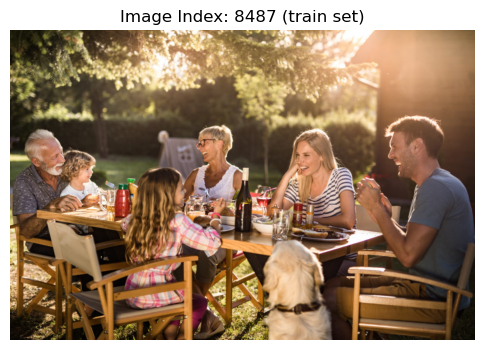

Top 5 scene categories for index 8487 in train set:
beer_garden: 92.80%
picnic_area: 2.68%
restaurant_patio: 2.26%
patio: 0.57%
restaurant: 0.54%


In [ ]:
# def inspect_scene_logits(idx, subset):
#     if subset == "train":
#         data = df_train
#     else:
#         data = df_test

#     logits_path = os.path.join(scene_feature365_dir, subset, f"{idx}.pt")
#     if not os.path.exists(logits_path):
#         print(f"Logits file does not exist: {logits_path}")
#         return

#     logits = torch.load(logits_path)
#     top5_prob, top5_catid = torch.topk(torch.softmax(logits, dim=0), 5)

#     # Display corresponding image
#     img_path = os.path.join(findingemo_dir, data.loc[idx, 'image_path'])
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     plt.figure(figsize=(6, 6))
#     plt.imshow(img)
#     plt.title(f"Image Index: {idx} ({subset} set)")
#     plt.axis('off')
#     plt.show()
    
#     print(f"Top 5 scene categories for index {idx} in {subset} set:")
#     for i in range(top5_prob.size(0)):
#         print(f"{scene_categories[top5_catid[i]]}: {top5_prob[i].item()*100:.2f}%")

# inspect_scene_logits(idx = random.randint(0, len(df_train) - 1), subset="train")
# # inspect_scene_logits(idx = 0, subset="train")

In [362]:
class TruncatedFaceModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        out = self.base_model(x)
        logits = out.logits
        return logits[:, :6]  # keep only first 6

face_model_truncated = TruncatedFaceModel(face_model)
face_model_truncated.eval()

for p in face_model_truncated.parameters():
    p.requires_grad = False   # frozen

In [ ]:
class TruncatedSceneModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        

In [363]:
detector = MTCNN()
face_model.to(device)
img_path = os.path.join(findingemo_dir, df_train.loc[0, 'image_path'])
img = Image.open(img_path).convert("RGB")

max_size = 2048  # Maximum dimension

if max(img.size) > max_size:
    ratio = max_size / max(img.size)
    new_size = tuple(int(dim * ratio) for dim in img.size)
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    print(f"Resized image {i} from large size to {new_size}")

img_np = np.array(img)
faces = detector.detect_faces(img_np)
logits_original = []

if faces:
    faces = sorted(faces, key=lambda f: f["box"][2] * f["box"][3], reverse=True)[:3]  # keep up to 3 largest faces
    crops = []
    for fdet in faces:
        x, y, w, h = fdet["box"]
        x, y = max(0, x), max(0, y)
        x2, y2 = min(img_np.shape[1], x + w), min(img_np.shape[0], y + h)
        crop = img_np[y:y2, x:x2]
        if crop.shape[0] < 10 or crop.shape[1] < 10:
            continue
        face_tensor = face_processor(images=Image.fromarray(crop), return_tensors="pt")["pixel_values"].squeeze(0)
        crops.append(face_tensor)
    if crops:
        batch = torch.stack(crops).to(device)
        with torch.no_grad():
            out = face_model(batch)
            logits = out.logits.cpu()
        for i, fdet in enumerate(faces):
            logits_original.append(logits[i])

In [364]:
detector = MTCNN()
face_model_truncated.to(device)

img_path = os.path.join(findingemo_dir, df_train.loc[0, 'image_path'])
img = Image.open(img_path).convert("RGB")

max_size = 2048  # Maximum dimension

if max(img.size) > max_size:
    ratio = max_size / max(img.size)
    new_size = tuple(int(dim * ratio) for dim in img.size)
    img = img.resize(new_size, Image.Resampling.LANCZOS)
    print(f"Resized image {i} from large size to {new_size}")

img_np = np.array(img)
faces = detector.detect_faces(img_np)
logits_truncated = []
if faces:
    faces = sorted(faces, key=lambda f: f["box"][2] * f["box"][3], reverse=True)[:3]  # keep up to 3 largest faces
    crops = []
    for fdet in faces:
        x, y, w, h = fdet["box"]
        x, y = max(0, x), max(0, y)
        x2, y2 = min(img_np.shape[1], x + w), min(img_np.shape[0], y + h)
        crop = img_np[y:y2, x:x2]
        if crop.shape[0] < 10 or crop.shape[1] < 10:
            continue
        face_tensor = face_processor(images=Image.fromarray(crop), return_tensors="pt")["pixel_values"].squeeze(0)
        crops.append(face_tensor)

    if crops:
        batch = torch.stack(crops).to(device)
        with torch.no_grad():
            out = face_model_truncated(batch)
        for i, fdet in enumerate(faces):
            logits_truncated.append(out[i])

In [365]:
assert len(logits_original) == len(logits_truncated)
for i in range(len(logits_original)):
    print(f"Face {i}:")
    print("Original logits:", logits_original[i])
    print("Truncated logits:", logits_truncated[i])
    print()

Face 0:
Original logits: tensor([-0.2959, -2.5035,  0.5354, -0.8110,  4.0392, -1.5357, -1.5070])
Truncated logits: tensor([-0.2959, -2.5035,  0.5354, -0.8110,  4.0392, -1.5357], device='cuda:0')

Face 1:
Original logits: tensor([-1.0524, -2.2824, -0.5259, -2.4327,  2.8070,  3.7185, -2.3967])
Truncated logits: tensor([-1.0524, -2.2824, -0.5259, -2.4327,  2.8070,  3.7185], device='cuda:0')

Face 2:
Original logits: tensor([-0.6956, -1.1049,  1.4585, -2.2307, -0.8984,  4.0905, -2.0630])
Truncated logits: tensor([-0.6956, -1.1049,  1.4585, -2.2307, -0.8984,  4.0905], device='cuda:0')



In [366]:
detector = MTCNN()

def preprocess_face_logits(save_root, subset, base_findingemo_dir, max_faces = 3, starting_point = None):
    save_dir = os.path.join(save_root, subset)
    os.makedirs(save_dir, exist_ok=True)

    if subset == "train":
        data = df_train
    else:
        data = df_test

    if starting_point:
        data = data[starting_point:]

    for i, row in tqdm(data.iterrows(), total=len(data), desc=f"Processing {subset}"):
        img_path = os.path.join(base_findingemo_dir, row["image_path"])

        # check if the file already exists
        save_path = os.path.join(save_dir, f"{i}.pt")
        if os.path.exists(save_path):
            try:
                loaded_tensor = torch.load(save_path)
                if loaded_tensor.shape == (max_faces, 6):
                    continue
            except:
                pass

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {i}: {e}")
            stacked = torch.zeros(max_faces, 6)
            torch.save(stacked, save_path)
            continue

        max_size = 2048
        if max(img.size) > max_size:
            ratio = max_size / max(img.size)
            new_size = tuple(int(dim * ratio) for dim in img.size)
            img = img.resize(new_size, Image.Resampling.LANCZOS)
            print(f"Resized image {i} from large size to {new_size}")

        img_np = np.array(img)
        faces = detector.detect_faces(img_np)
        face_logits_list = []

        if faces:
            faces = sorted(faces, key=lambda f: f["box"][2] * f["box"][3], reverse=True)[:max_faces]
            crops = []
            for fdet in faces:
                x, y, w, h = fdet["box"]
                x, y = max(0, x), max(0, y)
                x2, y2 = min(img_np.shape[1], x + w), min(img_np.shape[0], y + h)
                crop = img_np[y:y2, x:x2]
                if crop.shape[0] < 10 or crop.shape[1] < 10:
                    continue
                face_tensor = face_processor(images=Image.fromarray(crop), return_tensors="pt")["pixel_values"].squeeze(0)
                crops.append(face_tensor)

            if crops:
                batch = torch.stack(crops).to(device)
                with torch.no_grad():
                    logits = face_model_truncated(batch)
                # Keep on GPU and extend directly
                face_logits_list.extend(logits)

        # Create zero tensors on GPU for padding
        while len(face_logits_list) < max_faces:
            face_logits_list.append(torch.zeros(6, device=device))

        # Stack on GPU, then move to CPU only once for saving
        stacked = torch.stack(face_logits_list[:max_faces]).cpu()  # (3,6)
        torch.save(stacked, save_path)

# preprocess_face_logits(save_root=faces_feature_dir, subset="train", base_findingemo_dir=findingemo_dir, max_faces=3)
# preprocess_face_logits(save_root=faces_feature_dir, subset="test", base_findingemo_dir=findingemo_dir, max_faces=3)

In [369]:
torch.load(os.path.join(faces_feature_dir, "train", "0.pt")).shape

torch.Size([3, 6])